In [35]:
import yfinance as yf
import time
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tabulate import tabulate
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [36]:
tick = ['ZEC-USD']
start_date = datetime(2023, 10, 1).strftime('%Y-%m-%d')
end_date = datetime(2024, 10, 1).strftime('%Y-%m-%d')

In [37]:
df = yf.download(tick, start= start_date , end = end_date )[['Close', 'Volume']]

[*********************100%***********************]  1 of 1 completed


In [38]:
df.isnull().sum()

Price   Ticker 
Close   ZEC-USD    0
Volume  ZEC-USD    0
dtype: int64

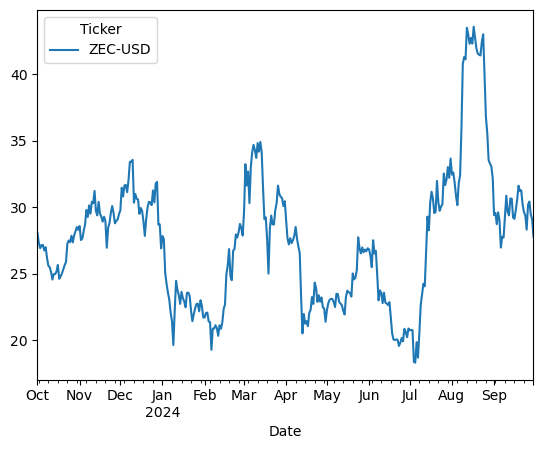

In [39]:
#first visualise data 
df['Close'].plot()
plt.show()

In [40]:
df['Close_smooth'] = df['Close'].rolling(window=3).mean()

# 3. Add day of the week (0 = Monday, 6 = Sunday)
df['day_of_week'] = df.index.dayofweek

# 4. Drop rows with NaN from rolling mean
df = df.dropna()

# 5. Reorder columns (optional but nice)
df = df[['Close_smooth', 'Volume', 'day_of_week']]

In [41]:
df

Price,Close_smooth,Volume,day_of_week
Ticker,,ZEC-USD,
Date,,,
2023-10-03,27.427790,39276194,1
2023-10-04,27.122104,40237126,2
2023-10-05,27.072433,39176880,3
2023-10-06,27.014357,40797786,4
2023-10-07,26.961298,36002104,5
...,...,...,...
2024-09-26,29.298665,73025475,3
2024-09-27,29.644467,67969445,4


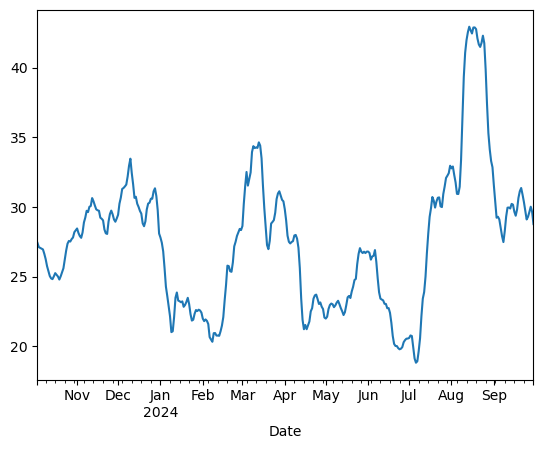

In [42]:
#first visualise data 
df['Close_smooth'].plot()
plt.show()

In [43]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

def create_seq2seq_dataset(data, time_step=60, forecast_horizon=20):
    X, y = [], []
    for i in range(len(data) - time_step - forecast_horizon):
        X.append(data[i:i + time_step])
        y.append(data[i + time_step:i + time_step + forecast_horizon, 0])  # Predict only 'Close_smooth'
    return np.array(X), np.array(y)


time_step = 60
forecast_horizon = 20

X, y = create_seq2seq_dataset(scaled_data, time_step, forecast_horizon)
X = X.reshape(X.shape[0], X.shape[1], scaled_data.shape[1])  # (samples, time_steps, features)

# Train/test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [44]:
model = Sequential()
model.add(LSTM(256, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.4))

model.add(LSTM(256))
model.add(Dropout(0.3))

model.add(Dense(forecast_horizon))  

model.compile(optimizer='adam', loss='mean_absolute_error')
model.summary()

C:\Users\asus\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                        │ (None, 60, 256)             │         266,240 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 60, 256)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 256)                 │         525,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 20)                  │           5,140 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 796,692 (3.04 MB)

 Trainable params: 796,692 (3.04 MB)

 Non-trainable params: 0 (0.00 B)

In [45]:
history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 136ms/step - loss: 0.2050 - val_loss: 0.2087
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.1511 - val_loss: 0.2035
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.1251 - val_loss: 0.1936
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.1200 - val_loss: 0.1780
Epoch 5/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.1126 - val_loss: 0.1554
Epoch 6/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.1117 - val_loss: 0.1679
Epoch 7/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.1030 - val_loss: 0.1876
Epoch 8/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0990 - val_loss: 0.1543
Epoch 9/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0996 - val_loss: 0.1424
Epoch 10/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.1032 - val_loss: 0.1117
Epoch 11/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0974 - val_loss: 0.1807
Epoch 12/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.1036 - val_loss: 0.1213


In [47]:
predicted_seq = model.predict(X_test)  # shape: (samples, 20)

# Pad and inverse transform
def inverse_transform_sequence(seq_pred):
    padded = np.concatenate([seq_pred.reshape(-1, 1), np.zeros((seq_pred.size, 2))], axis=1)
    return scaler.inverse_transform(padded)[:, 0]

# Apply to all predictions
predicted_prices_all = np.array([inverse_transform_sequence(p) for p in predicted_seq])
y_test_rescaled = np.array([inverse_transform_sequence(y) for y in y_test])


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 256ms/step


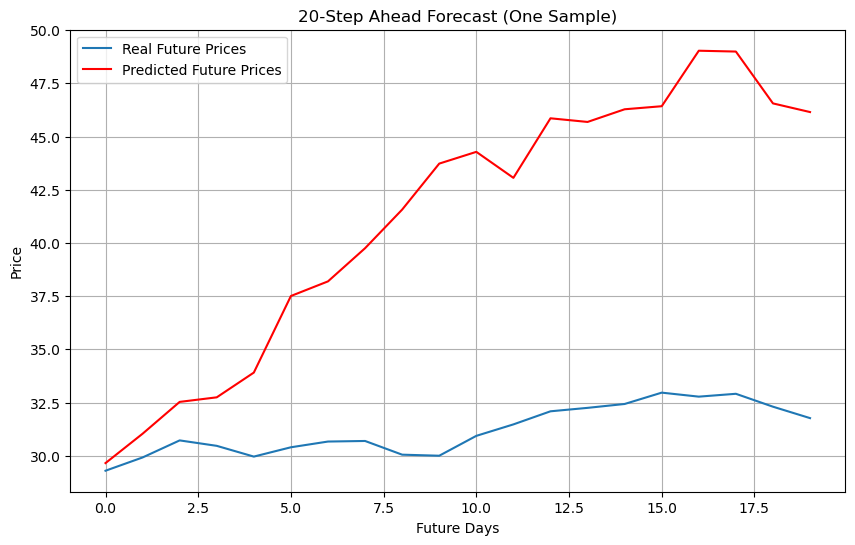

In [48]:
plt.figure(figsize=(10,6))
plt.plot(y_test_rescaled[0], label="Real Future Prices")
plt.plot(predicted_prices_all[0], label="Predicted Future Prices", color='red')
plt.title("20-Step Ahead Forecast (One Sample)")
plt.xlabel("Future Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


In [49]:
y_true = y_test_rescaled.flatten()
y_pred = predicted_prices_all.flatten()

mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R² Score: {r2:.4f}")

Mean Absolute Error (MAE): 7.5419
Mean Squared Error (MSE): 84.5014
R² Score: -2.0419


In [50]:
time_step = 60
future_steps = 20

# Start with the last sequence of shape (60, 3)
last_sequence = scaled_data[-time_step:]  # shape: (60, 3)
input_seq = last_sequence.reshape(1, time_step, scaled_data.shape[1])  # (1, 60, 3)

# List to store predictions
future_predictions = []

for _ in range(future_steps):
    # Predict only the 'Close_smooth' (1 value)
    next_pred = model.predict(input_seq, verbose=0)
    future_predictions.append(next_pred[0, 0])
    
    # Create dummy values for other features (Volume, Day of Week)
    dummy_volume = 0  # or use the last known scaled value
    dummy_day_of_week = (input_seq[0, -1, 2] + 1) % 7 / 6  # normalize to [0, 1]

    # Form new timestep with predicted close + dummy values
    next_input = np.array([[next_pred[0, 0], dummy_volume, dummy_day_of_week]])
    
    # Append new timestep, remove oldest timestep
    input_seq = np.append(input_seq[:, 1:, :], next_input.reshape(1, 1, 3), axis=1)

# Inverse scale predictions
# Pad with zeros for missing features to match scaler input
padded_predictions = np.concatenate([
    np.array(future_predictions).reshape(-1, 1),
    np.zeros((future_steps, 2))  # for Volume and day_of_week
], axis=1)

# Inverse transform only the Close_smooth
future_predictions_actual = scaler.inverse_transform(padded_predictions)[:, 0]

# Print results
print("Forecast for next 20 days:")
print(future_predictions_actual)


Forecast for next 20 days:
[28.57790362 28.31730562 28.05099806 27.83737717 27.71477596 27.65104236
 27.63680365 27.6493236  27.67465235 27.67446984 27.64109624 27.57329854
 27.44477651 27.25162844 26.99170013 26.66843773 26.29020942 25.86775388
 25.4231391  24.95655908]


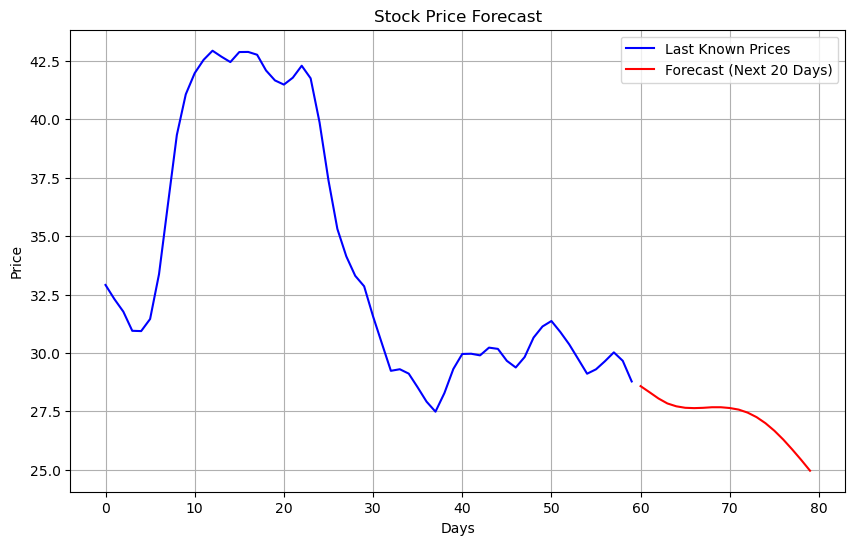

In [51]:
import matplotlib.pyplot as plt

# Prepare the last known real prices (for plotting continuity)
last_known_scaled = scaled_data[-time_step:, 0]  # Only 'Close_smooth' feature
last_known_padded = np.concatenate([
    last_known_scaled.reshape(-1, 1),
    np.zeros((time_step, 2))
], axis=1)

last_known_prices = scaler.inverse_transform(last_known_padded)[:, 0]  # Only the Close values

# Combine last known with future predictions
forecast_plot = np.concatenate((last_known_prices, future_predictions_actual.flatten()))

# Plot
plt.figure(figsize=(10, 6))
plt.plot(range(len(last_known_prices)), last_known_prices, label='Last Known Prices', color='blue')
plt.plot(range(len(last_known_prices), len(forecast_plot)), future_predictions_actual, label='Forecast (Next 20 Days)', color='red')
plt.title("Stock Price Forecast")
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


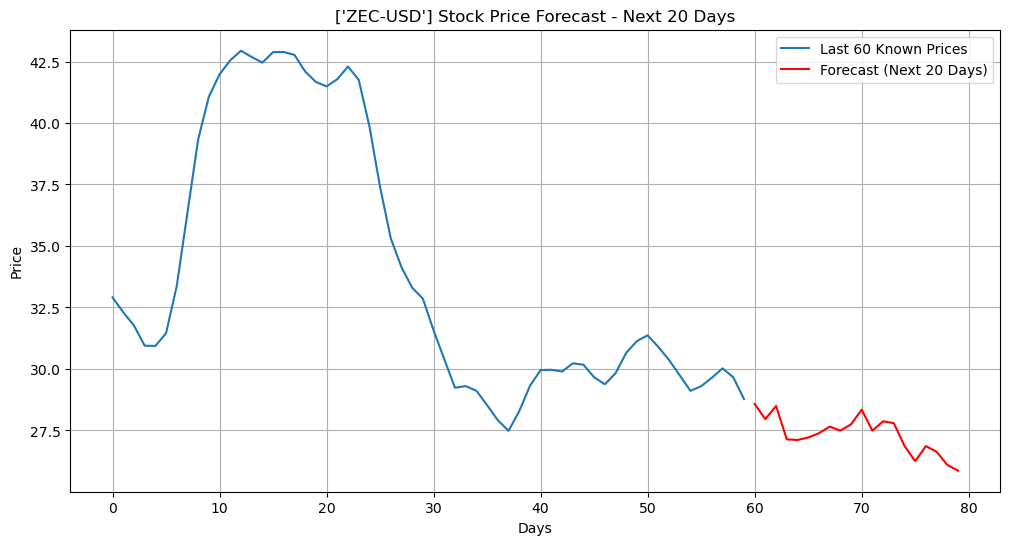

In [52]:
# Get the last 60 timesteps from the entire scaled dataset
last_input_seq = scaled_data[-time_step:]  # shape: (60, 3)
last_input_seq = last_input_seq.reshape(1, time_step, scaled_data.shape[1])  # shape: (1, 60, 3)
future_prediction_scaled = model.predict(last_input_seq)  # shape: (1, 20)
future_prediction_scaled = future_prediction_scaled[0]    # shape: (20,)
# Pad with dummy columns to match scaler's 3-feature input
padded_future_preds = np.concatenate([
    future_prediction_scaled.reshape(-1, 1),  # predicted close_smooth
    np.zeros((forecast_horizon, 2))           # dummy Volume and day_of_week
], axis=1)

# Inverse transform
future_prediction_actual = scaler.inverse_transform(padded_future_preds)[:, 0]
# Get last known real prices for context (unscale them)
last_known_scaled = scaled_data[-time_step:, 0].reshape(-1, 1)  # only Close_smooth
padded_last_known = np.concatenate([last_known_scaled, np.zeros((time_step, 2))], axis=1)
last_known_actual = scaler.inverse_transform(padded_last_known)[:, 0]

# Combine for plotting
full_forecast_plot = np.concatenate((last_known_actual, future_prediction_actual))

plt.figure(figsize=(12, 6))
plt.plot(range(len(last_known_actual)), last_known_actual, label='Last 60 Known Prices')
plt.plot(range(len(last_known_actual), len(full_forecast_plot)), future_prediction_actual, label='Forecast (Next 20 Days)', color='red')
plt.title(f'{tick} Stock Price Forecast - Next 20 Days')
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


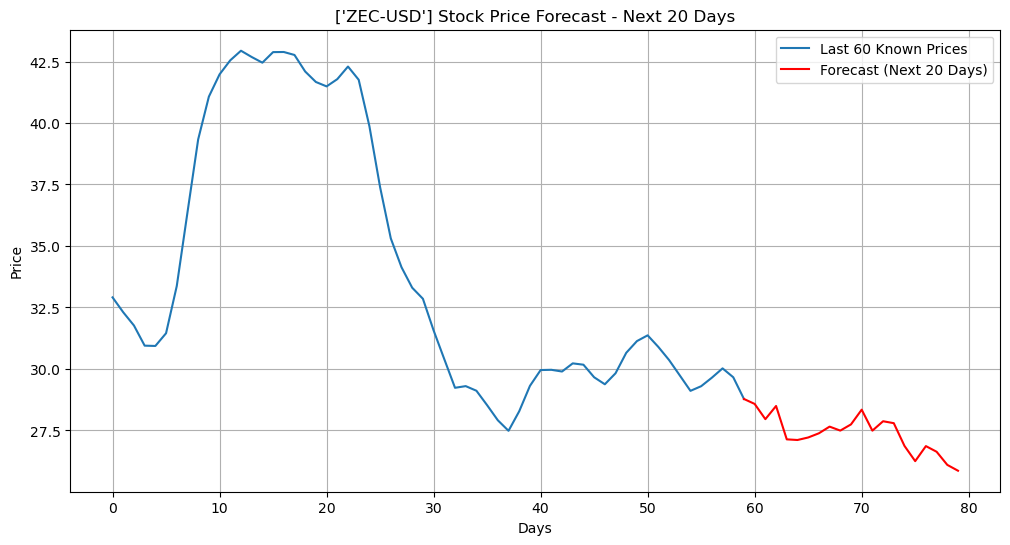

In [53]:
# Add last known actual price to the forecast line
future_prediction_actual_with_anchor = np.concatenate((
    [last_known_actual[-1]],  # anchor point
    future_prediction_actual
))

# Extend the x-axis accordingly
plt.figure(figsize=(12, 6))
plt.plot(range(len(last_known_actual)), last_known_actual, label='Last 60 Known Prices')
plt.plot(range(len(last_known_actual)-1, len(last_known_actual) + forecast_horizon), 
         future_prediction_actual_with_anchor, 
         label='Forecast (Next 20 Days)', color='red')
plt.title(f'{tick} Stock Price Forecast - Next 20 Days')
plt.xlabel("Days")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()
